
# Transformers for Sentiment Analysis


## Getting Started

First, set up the necessary libraries for the transformer

In [ ]:
pip install torchtext

In [ ]:
import spacy.cli
spacy.cli.download("en_core_web_sm")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [ ]:
pip install transformers

## Preparing Data

First, set the random seeds for deterministic results.

In [ ]:
import torch

import random
import numpy as np

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

The transformer has already been trained with a specific vocabulary, which means we need to train with the exact same vocabulary and also tokenize our data in the same way that the transformer did when it was initially trained.

Luckily, the transformers library has tokenizers for each of the transformer models provided. In this case we are using the BERT model which ignores casing (i.e. will lower case every word). We get this by loading the pre-trained `bert-base-uncased` tokenizer.

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

The transformer was also trained with special tokens to mark the beginning and end of the sentence, detailed [here](https://huggingface.co/transformers/model_doc/bert.html#transformers.BertModel). As well as a standard padding and unknown token. We can also get these from the tokenizer.

**Note**: the tokenizer does have a beginning of sequence and end of sequence attributes (`bos_token` and `eos_token`) but these are not set and should not be used for this transformer.

In [ ]:
init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

print(init_token, eos_token, pad_token, unk_token)

[CLS] [SEP] [PAD] [UNK]


We can get the indexes of the special tokens by converting them using the vocabulary...

In [ ]:
init_token_idx = tokenizer.convert_tokens_to_ids(init_token)
eos_token_idx = tokenizer.convert_tokens_to_ids(eos_token)
pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)
unk_token_idx = tokenizer.convert_tokens_to_ids(unk_token)

print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)

101 102 0 100


...or by explicitly getting them from the tokenizer.

In [ ]:
init_token_idx = tokenizer.cls_token_id
eos_token_idx = tokenizer.sep_token_id
pad_token_idx = tokenizer.pad_token_id
unk_token_idx = tokenizer.unk_token_id

print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)

101 102 0 100


Another thing we need to handle is that the model was trained on sequences with a defined maximum length - it does not know how to handle sequences longer than it has been trained on.

In [ ]:
max_input_length = 200

print(max_input_length)

200


Load the data and create the training/validation/test splits.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd

df = pd.read_csv('/content/gdrive/My Drive/kaggle/input/twitter-and-reddit-sentimental-analysis-dataset/Twitter_Data.csv', dtype=str)

Clean up the data.

In [ ]:
df.dropna(inplace=True)

In [ ]:
df['category']=df['category'].astype(str).astype(int)

In [ ]:
df['clean_text']=df['clean_text'].astype(str)

In [ ]:
cat = list(df['category'])
neutral = [i for i, e in enumerate(cat) if e == 0]
df = df.drop(df.index[neutral])

In [ ]:
df['category'] = df['category'].replace([-1], 0)

In [ ]:
df = df[:5000]

In [ ]:
df

,clean_text,category
0,when modi promised “minimum government maximum...,0
2,what did just say vote for modi welcome bjp t...,1
3,asking his supporters prefix chowkidar their n...,1
4,answer who among these the most powerful world...,1
8,with upcoming election india saga going import...,1
...,...,...
15292,nirav modi has been siphoning these monies sin...,1
15293,doubt this guy have the plan scrap modi’ ayush...,0
15295,siddhu this the naya pakistan your beloved fri...,1
15296,the good news people didnt forced see the pict...,1


In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(
  df,
  test_size=0.3,
  random_state=random.seed(SEED)
)

valid_data, test_data = train_test_split(
  test_data,
  test_size=0.5,
  random_state=random.seed(SEED)
)

In [ ]:
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 7000
Number of validation examples: 1500
Number of testing examples: 1500


We can check an example and ensure that the text has already been numericalized.

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
class TwitterDataset(Dataset):
  def __init__(self, tweets, targets, tokenizer, max_len):
    self.tweets = tweets
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_input_length

  def __len__(self):
    return len(self.tweets)
  
  def __getitem__(self, item):
    tweets = str(self.tweets[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      tweets,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )
  
    return {
      'tweet_text': tweets,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

Next, reate dataloaders with the defined batch sized. 

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = TwitterDataset(
    tweets=df.clean_text.to_numpy(),
    targets=df.category.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
import torch.nn as nn

In [ ]:
BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_data_loader = create_data_loader(train_data,tokenizer,max_input_length,BATCH_SIZE)
val_data_loader = create_data_loader(valid_data,tokenizer,max_input_length,BATCH_SIZE)
test_data_loader = create_data_loader(test_data,tokenizer,max_input_length,BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
data = next(iter(train_data_loader))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([32, 200])
torch.Size([32, 200])
torch.Size([32])


## Build the Model

Load the pre-trained model.

**Note**: make sure to load the same model as we did for the tokenizer.

In [ ]:
from transformers import BertTokenizer, BertModel

bert = BertModel.from_pretrained('bert-base-uncased')

Next, we'll define our actual model. 

Instead of using an embedding layer to get embeddings for our text, we'll be using the pre-trained transformer model. These embeddings will then be fed into a GRU to produce a prediction for the sentiment of the input sentence. We get the embedding dimension size (called the `hidden_size`) from the transformer via its config attribute. The rest of the initialization is standard.

Within the forward pass, we wrap the transformer in a `no_grad` to ensure no gradients are calculated over this part of the model. The transformer actually returns the embeddings for the whole sequence as well as a *pooled* output. The [documentation](https://huggingface.co/transformers/model_doc/bert.html#transformers.BertModel) states that the pooled output is "usually not a good summary of the semantic content of the input, you’re often better with averaging or pooling the sequence of hidden-states for the whole input sequence", hence we will not be using it. The rest of the forward pass is the standard implementation of a recurrent model, where we take the hidden state over the final time-step, and pass it through a linear layer to get our predictions.

In [ ]:
class BERTGRUSentiment(nn.Module):
    def __init__(self,
                 bert,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        
        super().__init__()
        self.bert = bert
        embedding_dim = bert.config.to_dict()['hidden_size']
        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        with torch.no_grad():
            embedded = self.bert(text)[0]
        _, hidden = self.rnn(embedded)
        
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
                
        output = self.out(hidden)
        
        return output


Create an instance of our model using standard hyperparameters.

In [ ]:
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25

model = BERTGRUSentiment(bert,
                         HIDDEN_DIM,
                         OUTPUT_DIM,
                         N_LAYERS,
                         BIDIRECTIONAL,
                         DROPOUT)

We can check how many parameters the model has. Our standard models have under 5M, but this one has 112M! Luckily, 110M of these parameters are from the transformer and we will not be training those.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 112,241,409 trainable parameters


In order to freeze paramers (not train them) we need to set their `requires_grad` attribute to `False`. To do this, we simply loop through all of the `named_parameters` in our model and if they're a part of the `bert` transformer model, we set `requires_grad = False`. 

In [ ]:
for name, param in model.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = False

We can now see that our model has under 3M trainable parameters, making it almost comparable to the `FastText` model. However, the text still has to propagate through the transformer which causes training to take considerably longer.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,759,169 trainable parameters


We can double check the names of the trainable parameters, ensuring they make sense. As we can see, they are all the parameters of the GRU (`rnn`) and the linear layer (`out`).

In [ ]:
for name, param in model.named_parameters():                
    if param.requires_grad:
        print(name)

rnn.weight_ih_l0
rnn.weight_hh_l0
rnn.bias_ih_l0
rnn.bias_hh_l0
rnn.weight_ih_l0_reverse
rnn.weight_hh_l0_reverse
rnn.bias_ih_l0_reverse
rnn.bias_hh_l0_reverse
rnn.weight_ih_l1
rnn.weight_hh_l1
rnn.bias_ih_l1
rnn.bias_hh_l1
rnn.weight_ih_l1_reverse
rnn.weight_hh_l1_reverse
rnn.bias_ih_l1_reverse
rnn.bias_hh_l1_reverse
out.weight
out.bias


## Train the Model

As is standard, we define our optimizer and criterion, i.e., loss function.

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [ ]:
criterion = nn.BCEWithLogitsLoss()

Place the model and criterion onto the GPU (if available)

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

Next,  define functions for preprocessing each batch, calculating accuracy, performing a training epoch, performing an evaluation epoch and calculating how long a training/evaluation epoch takes.

In [ ]:
def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence) 
    tokens = tokens[:max_input_length-2]
    return tokens

In [ ]:
def preprocess(batch):
    tweet_texts = []
    for tweet in batch['tweet_text']:
        tokens = tokenize_and_cut(tweet)
        text = tokenizer.convert_tokens_to_ids(tokens)
        # pad with pad_token_idx
        text += [pad_token_idx] * (max_input_length - len(text))
        tweet_texts.append(torch.Tensor(text, ))

    text_tensor = torch.stack(tweet_texts).to(dtype=torch.long)  # (128, 200)

    return text_tensor

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def train(model, dataloader, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    count = 0

    model.train()
    
    for batch in dataloader:
        
        targets = batch["targets"].to(device)

        optimizer.zero_grad()

        text = preprocess(batch).to(device)
        
        predictions = model(text).squeeze(1).to(device)
        
        loss = criterion(predictions, targets.type_as(predictions))
        
        acc = binary_accuracy(predictions, targets)

        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        count += 1
        
    return epoch_loss / count, epoch_acc / count

In [ ]:
def evaluate(model, dataloader, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    count = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in dataloader:
            
            targets = batch["targets"].to(device)

            text = preprocess(batch).to(device)

            predictions = model(text).squeeze(1).to(device)
            
            loss = criterion(predictions, targets.type_as(predictions))
            
            acc = binary_accuracy(predictions, targets.type_as(predictions))

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            count += 1

    return epoch_loss / count, epoch_acc / count

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we'll train our model. This takes considerably longer than any of the previous models due to the size of the transformer. Even though we are not training any of the transformer's parameters we still need to pass the data through the model which takes a considerable amount of time on a standard GPU.

In [ ]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()

In [ ]:
N_EPOCHS = 5
best_valid_loss = float('inf')

all_train_acc, all_train_loss = [], []
all_valid_acc, all_valid_loss = [], []

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_data_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_data_loader, criterion)

    all_train_acc.append(train_acc)
    all_train_loss.append(train_loss)
    all_valid_acc.append(valid_acc)
    all_valid_loss.append(valid_loss)

    end_time = time.time()
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'transformer_model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 01 | Epoch Time: 2m 10s
	Train Loss: 0.672 | Train Acc: 60.77%
	 Val. Loss: 0.637 |  Val. Acc: 63.26%
Epoch: 02 | Epoch Time: 2m 10s
	Train Loss: 0.649 | Train Acc: 62.76%
	 Val. Loss: 0.618 |  Val. Acc: 65.66%
Epoch: 03 | Epoch Time: 2m 10s
	Train Loss: 0.633 | Train Acc: 63.88%
	 Val. Loss: 0.612 |  Val. Acc: 66.25%
Epoch: 04 | Epoch Time: 2m 10s
	Train Loss: 0.629 | Train Acc: 64.11%
	 Val. Loss: 0.614 |  Val. Acc: 66.53%
Epoch: 05 | Epoch Time: 2m 10s
	Train Loss: 0.620 | Train Acc: 65.24%
	 Val. Loss: 0.622 |  Val. Acc: 65.65%


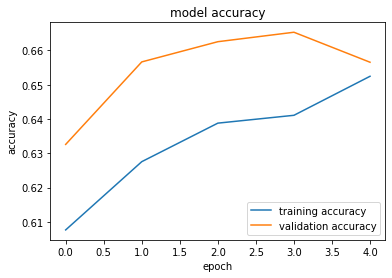

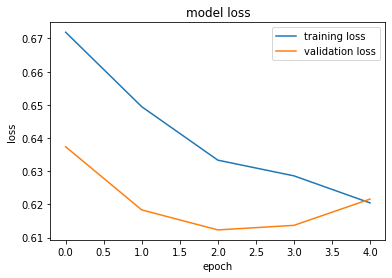

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(list(range(N_EPOCHS)), all_train_acc, label="training accuracy")
plt.plot(list(range(N_EPOCHS)), all_valid_acc, label="validation accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("model accuracy")
plt.legend()
plt.show()

plt.plot(list(range(N_EPOCHS)), all_train_loss, label="training loss")
plt.plot(list(range(N_EPOCHS)), all_valid_loss, label="validation loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("model loss")
plt.legend()
plt.show()

We'll load up the parameters that gave us the best validation loss and try these on the test set - which gives us our best results so far!

In [ ]:
model.load_state_dict(torch.load('transformer_model.pt'))

test_loss, test_acc = evaluate(model, test_data_loader, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Test Loss: 0.620 | Test Acc: 65.58%
